In [1]:
import os
import sys

from collections import defaultdict, Counter
from tqdm.notebook import tqdm_notebook

import numpy as np
import pandas as pd
import scipy.stats as sps
import scipy.sparse as scsp
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ndcg_score, dcg_score, roc_auc_score, average_precision_score
from sklearn.metrics.pairwise import cosine_similarity

from joblib import Parallel, delayed

import tqdm
import json

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output

sns.set()

# Датасет

In [2]:
!wget -O zen_dataset.tar.gz https://www.dropbox.com/s/15mkthbvlturbsz/zen_dataset.tar.gz?dl=0
!tar -xzvf zen_dataset.tar.gz

--2023-05-14 13:54:50--  https://www.dropbox.com/s/15mkthbvlturbsz/zen_dataset.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/15mkthbvlturbsz/zen_dataset.tar.gz [following]
--2023-05-14 13:54:51--  https://www.dropbox.com/s/raw/15mkthbvlturbsz/zen_dataset.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc27ca56f402095f2d50f0c4adbd.dl.dropboxusercontent.com/cd/0/inline/B8CX9RWipBnwRjTur6eeVb3ygvQAT1j81LNdxsllSPLCKn8GUn3XTnqf49eqgHsO17bqi_WplabpXS2kpduLO5wSk9Vk0ZoHAmn5oyTVeiSP5wPnku1KKC89zZqojqGV4slyYazb-PS0_O72CCPohJ3sFI98cbjOqD3UEH8pLY8jjg/file# [following]
--2023-05-14 13:54:51--  https://uc27ca56f402095f2d50f0c4adbd.dl.dropboxusercontent.com/cd/0/inline/B8CX9RWipBnwRjTur6eeVb3ygvQAT1j81LNdxsllSPLCKn8GUn3XTnqf4

In [3]:
item_counts = pd.read_csv('zen_dataset/item_counts.csv', index_col=0)
item_meta = pd.read_csv('zen_dataset/item_meta.gz', compression='gzip', index_col=0)
user_ratings = pd.read_csv('zen_dataset/user_ratings.gz', compression='gzip', index_col=0)

In [4]:
item_counts['itemId'] = item_counts['itemId'].apply(str)

Датасет состоит из текстовых статей и истории взаимодействия пользователей с ними.
* 105000 айтемов
* 95000 пользователей
* 40 млн взаимодействий

In [5]:
with pd.option_context('display.max_colwidth', 100):
    display(item_meta)

,itemId,title,content
0,5480844460835530524,"Нехитрые способы, как самостоятельно проверить качество воды из скважины или колодца","С раннего детства нам рассказывают, что самая вкусная и полезная вода – та, что добывается из ..."
1,25708764690236829,"Где находилась сверхсекретная база подводных лодок СССР, которую совершенно не видно с моря?","Сомневаюсь, что найдётся сейчас человек, который никогда не слышал о Балаклаве. Даже если допуст..."
2,25995859650472943,Тапки ( жуткий рассказ),"Год назад эту историю рассказала мне моя родственница и с её позволения, я хочу ей поделиться...."
3,26039067597386753,Крутые находки на Aliexpress №1113,"Доброго времени суток, Уважаемые читатели! Добро пожаловать на канал ""Чайна Таун"", где ежедневно..."
4,26225874317634871,Нам пообещали высокую инфляцию. Деньги сильно обесценятся — и целое поколение будет «жить в долгах»,"Цены в магазинах и темпы инфляции растут не только в нашей стране, но и практически во всех стра..."
...,...,...,...
104498,6221825086402198588,Сколько можно заработать на видеокартах с AGP интерфейсом,"Очень старые видеокарты с интерфейсом AGP, которые как кажется, никому уже не нужны. К нам в маг..."
104499,6221897338759013055,Укрытие Роз на зиму,По Вашим просьбам - повторяю пост прошлого года - про укрытие Роз ( с небольшой редакцией)\n\nЯ ...
104500,6221960724554910431,"Мама, мамочка, мамуля: снимки самого близкого человека на свете",В подборке снимков из нашего архива — фотографии мам со своими детьми времен царской России и СС...
104501,6222047264920702976,"Что лучше: сдавать наследственную квартиру или продать? Рассказываю, почему я выбрал второй вариант","""Кварта − новый бренд ПИК-Брокер"" Привет, меня зовут Андрей, мне 30 лет. Я вообще никогда не пис..."


In [6]:
user_encoder = LabelEncoder().fit(user_ratings['userId'])
item_encoder = LabelEncoder().fit(item_counts['itemId'])

In [7]:
all_items = item_counts['itemId']
indices = item_encoder.transform(all_items)
item_to_id = dict(zip(all_items, indices))

# SLIM

Пусть $R \in \mathbb{R}^{|U| \times |I|}$ &mdash; бинарная матрица взаимодействий пользователей и айтемов. Тогда SLIM оптимизирует

$$L = \frac{1}{2} \Vert R - RW \Vert_F^2 + \frac{\beta}{2} \Vert W \Vert_F^2 + \lambda \Vert W \Vert_1 \rightarrow \min_W,\\
  s.t. \forall i, j \; W_{ij} \geq 0, W_{ii} = 0.$$
  
Матрица $W$ &mdash; матрица попарных айтемых "взаимосвязей".

Сохраним по-айтемную историю.

Для ускорения будем использовать библиотеку `numba`. Она позволяет вместо компилятора Python использовать jit-компилятор питоновского кода, что, как правило, заметно ускоряет выполнение программы. Поддерживает не всю, но существенную часть функциональности Python, а именно
1. Классическая функциональность Python (списки, множества, словари и т.п.);
2. Библиотека numpy.

Перед названием функции нужно добавить `@numba.njit()`.

In [8]:
import numba

item_ratings_ind = [numba.typed.List() for _ in range(len(item_encoder.classes_))]
user_ids = user_encoder.transform(user_ratings['userId'])

for user_id, items_with_ratings in tqdm_notebook(zip(user_ids, user_ratings['trainRatings']), total=len(user_ratings)):
    item_ids, item_ratings = zip(*json.loads(items_with_ratings.replace("'", '"')).items())
    item_ids = [item_to_id[item_id] for item_id in item_ids]
    
    for item_id, rating in zip(item_ids, item_ratings):
        item_ratings_ind[item_id].append((user_id, rating))

  0%|          | 0/75910 [00:00<?, ?it/s]

In [9]:
item_ratings_ind_nb = numba.typed.List(item_ratings_ind)

In [16]:
@numba.njit()
def fit_one_item(item_ratings, j, n_iter=20, l2_reg=1.0, l1_reg=2.0):
    """
    Оптимизирует один столбец матрицы W
    * item_ratings -- список списков взаимодействий айтема,
      item_ratings[j] -- список взаимодействий айтема j с пользователями
    * j -- номер айтема, для которого ищем веса
    * n_iter -- количество итераций оптимизации
    * l1_reg, l2_reg -- коэффициенты регуляризации L1 и L2
    
    Возвращает dict: item -> вес, все ненулевые веса
    """
    n_items = len(item_ratings)
    per_item_positives = []
    item_interactions = set()

    for user, rating in item_ratings[j]:
        item_interactions.add(user)
    for i in range(n_items):
        positives = set()
        for user, rating in item_ratings[i]:
            if rating == 1 and user in item_interactions:
                positives.add(user)
        per_item_positives.append(positives)
        
    w = np.zeros(n_items)
    non_zero_items = set()

    for _ in range(n_iter):
        for k in range(n_items):
            if k == j:
                continue
            
            # <YOUR CODE HERE>
            score = len(per_item_positives[j] & per_item_positives[k]) - l1_reg
            for i in non_zero_items:
                if i == k:
                    continue
                score -= w[i] * len(per_item_positives[i] & per_item_positives[k])
                if score < 0:
                    break
            score /= len(per_item_positives[k]) + l2_reg
            score = max(score, 0.0)
            # -----------------

            w[k] = score
            if w[k] > 1e-5:
                non_zero_items.add(k)

    non_zero_elements = {}
    for i, value in enumerate(w):
        assert value >= 0.0
        if value > 0:
            non_zero_elements[i] = value

    return non_zero_elements

In [17]:
def get_item_meta(item_id):
    item_id = int(item_encoder.inverse_transform([item_id])[0])
    return item_meta[item_meta['itemId'] == item_id].iloc[0].to_dict()

def visualize_top(item_ratings_ind_nb, j, top=10):
    weights = fit_one_item(item_ratings_ind_nb, j)
    sorted_items = sorted(weights.items(), key=lambda x: x[1], reverse=True)[:top]

    item_ids, weights = zip(*sorted_items)
    items = map(get_item_meta, item_ids)
    anchor_item = get_item_meta(j)
    
    with pd.option_context('display.max_colwidth', 100):
        display(pd.DataFrame({
            anchor_item['title']: [item['title'] for item in items],
            'score': weights
        }))

In [18]:
visualize_top(item_ratings_ind_nb, 1)

,"7 новых комиксов от проекта «Мозги трески» - Волос в супе, послание в бутылке и другие истории",score
0,"""Только не почта!"" и другие адские места в 13 комиксах",0.267529
1,«Неучфан» - Серия хулиганских научно-фантастических комиксов в духе «Рика и Морти»,0.225984
2,"Комиксы, которые заставят ваши щёчки танцевать: 10 фото",0.166780
3,"Художник из Дюссельдорфа решил потренироваться рисовать на небольших комиксах, а в итоге именно ...",0.099529
4,Юморные комиксы о вечном противостоянии сердца и разума,0.057803
5,"Юморные комиксы, доказывающие, что с сарказмом жить легче",0.044580
6,12 забавных фактов о космосе в комиксах,0.030111
7,"Классические ужастики теперь вызывают только смех - 11 лучших комиксов про то, что раньше нас си...",0.015443
8,"Художник рисует комиксы с черным юмором, а получаются философские и поучительные",0.011485
9,10 веселых комиксов популярной серии «Глупые боги»,0.007130


In [19]:
visualize_top(item_ratings_ind_nb, 50)

,«Роскошная кухня после ремонта!» как выглядит квартира в Риге Татьяны Веденеевой - ФОТО,score
0,"Личная жизнь, карьера, внешность Таисии Повалий",0.172762
1,Убирайте из своих образов устаревшие стереотипы и после 60 вы будете молодой и стильной. А кому ...,0.145176
2,"Породистых леди видно сразу: 5 мелочей, которые выдают в женщине дешёвку!",0.140144
3,"4 российские актрисы, которые в 60-летнем возрасте выглядят на все 100",0.138545
4,Зрительница требует выгнать Милохина и почему Даниил Глейхенгауз желает победы Медведевой в шоу ...,0.113499
5,"Нет ничего страшнее того «поезда», под который она попала",0.111025
6,Прекрасная мама: Российские знаменитости и звезды шоу-бизнеса опубликовали трогательные и нежные...,0.104713
7,Что стало с бывшей женой-миллионершей и брошенным сыном Влада Сташевского,0.102414
8,"Любимая «мелодия» Муслима Магомаева, Тамара Синявская – в печали и в блеске драгоценностей после...",0.100501
9,"3 причины, почему я перестала звать гостей к себе домой, и дело не в экономии",0.100398


In [20]:
visualize_top(item_ratings_ind_nb, 100)

,Забияко после вылета раскрыла все карты и рассказала чем осталась недовольна на шоу Ледниковый период 2021,score
0,"3 гениальные еврейские пословицы, которые спасают от депрессии и хандры",0.243903
1,«Какое стильное пальтишко у Аллы Пугачёвой!» - редкие ФОТО с праздника примадонны,0.231321
2,Халтура с нарядами Алины Загитовой и по чьей протекции попал на Ледниковый период Федор Федотов,0.202943
3,"Три мировых рекорда и российский пьедестал. Что скажете, госпожа Дюамель?",0.148041
4,"Ледниковый период 8 выпуск, последняя номинация, лучшие пары, оценки дуэтов, рассказываем подроб...",0.146016
5,Загадка друзей Валентины Малявиной,0.137659
6,В день рождения он спешит на лед: Алексею Тихонову - 50. Тернистый путь в спорте и семья. Чем се...,0.132900
7,Что обычно ожидало русских казачек в руках у кавказских горцев. Рассказываем,0.128706
8,Костя Богомолов на сцене театра,0.128252
9,"Диана Анкудинова получила трогательное послание от Стаса Костюшкина. Тёплые отголоски ""Шоумаскгоон""",0.122691


# Нейросети


Как обсуждалось на лекции, как правило в нейросетевых рекомендациях используют архитектуры типа DSSM.

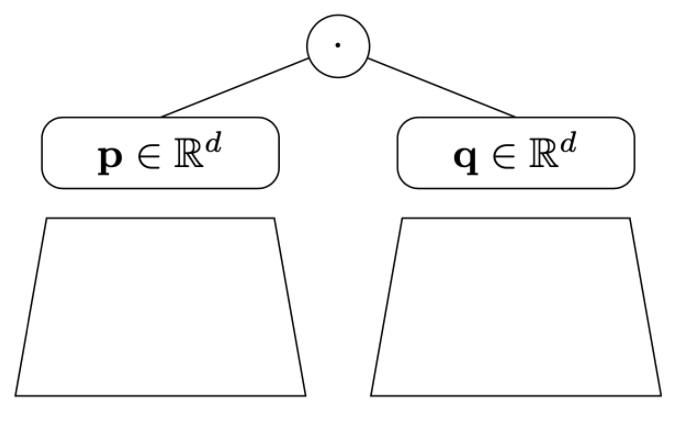


Модель состоит из двух нейросетевых частей:
1. Айтемная. Может принимать на вход контент документа, его статистики, признаки автора.
2. Пользовательская. Должна содержать некоторую агрегацию взаимодействий пользователя. 
   * В случае текстовых документов можно использовать bag of words сконкатенированных позитивов;
   * RNN по истории пользователя;
   * Transformer;
   * etc.

In [21]:
#!g1.1
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Создадим torch датасеты по train и test данным

In [22]:
#!g1.1
def make_dataset(user_ratings, rating_col):
    users, items, ratings = [], [], []
    user_ids = user_encoder.transform(user_ratings['userId'])
    for user_id, items_with_ratings in tqdm_notebook(zip(user_ids, user_ratings[rating_col]), total=len(user_ratings)):
        item_ids, item_ratings = zip(*json.loads(items_with_ratings.replace("'", '"')).items())
        item_ids = [item_to_id[item_id] for item_id in item_ids]
        # item_ids = item_encoder.transform(item_ids)

        for item_id, rating in zip(item_ids, item_ratings):
            users.append(user_id)
            items.append(item_id)
            ratings.append(rating)

    return TensorDataset(torch.tensor(users), torch.tensor(items), torch.tensor(ratings))

In [23]:
#!g1.1
train_dataset = make_dataset(user_ratings, 'trainRatings')
test_dataset = make_dataset(user_ratings, 'testRatings')

  0%|          | 0/75910 [00:00<?, ?it/s]

  0%|          | 0/75910 [00:00<?, ?it/s]

In [24]:
#!g1.1
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

В нашем семинаре реализуем самую простую возможную DSSM-like модель, модель обычной матричной факторизации.

In [28]:
#!g1.1
class MatrixDecompositionModel(nn.Module):
    def __init__(self, num_users, num_items, emb_size=10):
        super(MatrixDecompositionModel, self).__init__()
        
        # <YOUR CODE HERE>: user and item embeddings
        self.user_embeddings = nn.Embedding(num_users, emb_size) # OneHotEncoder -> Linear
        self.item_embeddings = nn.Embedding(num_items, emb_size)
        # -----------------
    
    def forward(self, users, items):
        # <YOUR CODE HERE>: dot-product for all pairs in batch
        user_embs = self.user_embeddings(users)
        item_embs = self.item_embeddings(items)
        dot_products = (user_embs * item_embs).sum(dim=-1)
        # -----------------
        return dot_products

In [29]:
#!g1.1
def plot_loss(train_loss, test_loss=None):
    clear_output(True)

    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Train')
    if test_loss is not None:
        plt.plot(test_loss, label='Test')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Train progress')
    plt.legend()
    
    plt.show()


def train(model, optimizer, train_loader, test_loader, num_epochs=5):
    train_loss_per_iteration = []

    for epoch in range(num_epochs):

        model.train()
        train_loss = 0.0

        for iteration, (users, items, ratings) in enumerate(tqdm_notebook(train_loader, total=len(train_loader))):
            users = users.to(device)
            items = items.to(device)
            ratings = ratings.to(device)

            optimizer.zero_grad()

            # <YOUR CODE HERE>: backward step
            ratings_pred = model(users, items)
            loss = F.mse_loss(ratings_pred, ratings.float())
            loss.backward()
            optimizer.step()
            # -----------------
            
            train_loss_per_iteration.append(loss.item())
            train_loss += loss.item()
            
            if iteration % 1000 == 0:
                plot_loss(train_loss_per_iteration)

        train_loss /= len(train_loader)
        
        model.eval()
        test_loss = 0.0
        
        for users, items, ratings in tqdm_notebook(test_loader, total=len(test_loader)):
            users = users.to(device)
            items = items.to(device)
            ratings = ratings.to(device)
            
            with torch.no_grad():
                ratings_pred = model(users, items)
            
            loss = F.mse_loss(ratings_pred, ratings.float())

            test_loss += loss.detach().cpu()
        test_loss /= len(test_loader)
        
        print(f'Epoch {epoch}: Train loss: {train_loss}, Test loss: {test_loss}')

In [30]:
#!g1.1
model = MatrixDecompositionModel(len(user_encoder.classes_), len(item_encoder.classes_), emb_size=8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

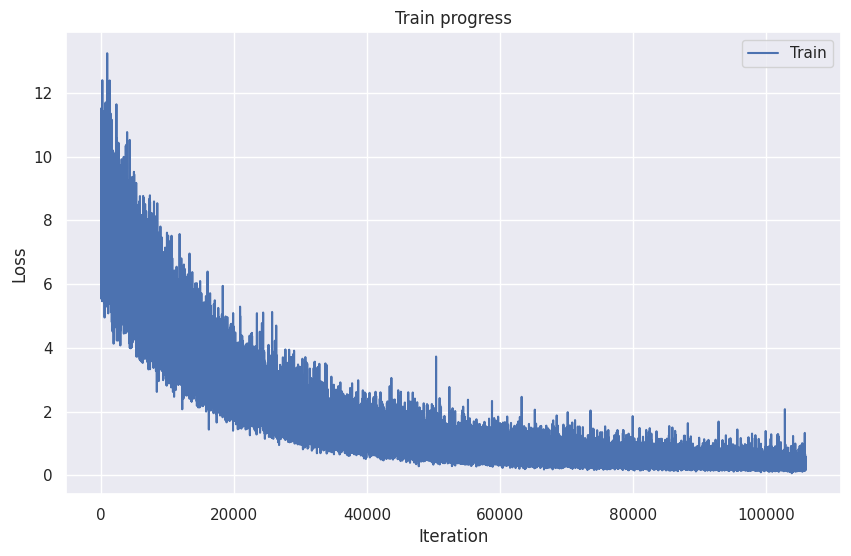

KeyboardInterrupt: ignored

In [31]:
#!g1.1
train(model, optimizer, train_loader, test_loader)